<a href="https://www.kaggle.com/erfansobhaei/dcgan-for-celeba?scriptVersionId=86995701" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

! pip install -q gdown
import gdown
from zipfile import ZipFile

In [2]:
# Original File Link: https://drive.google.com/drive/folders/0B7EVK8r0v71pTUZsaXdaSnZBZzg?resourcekey=0-rJlzl934LzC-Xp28GeIBzQ
url = "https://drive.google.com/uc?id=1iXJ0SSuvc0C9jnjlJ0Gy-pUTvbRxy8zg"
output = "data.zip"
gdown.download(url, output, quiet=False)

with ZipFile("./data.zip", "r") as zipobj:
    zipobj.extractall()

Downloading...
From: https://drive.google.com/uc?id=1iXJ0SSuvc0C9jnjlJ0Gy-pUTvbRxy8zg
To: /kaggle/working/data.zip
100%|██████████| 1.44G/1.44G [00:05<00:00, 241MB/s]


In [3]:
image_size = (64, 64)
batch_size = 32

dataset = keras.preprocessing.image_dataset_from_directory(
    "img_align_celeba",
    image_size=image_size,
    batch_size=batch_size,
    label_mode=None,
    seed=42,
)

dataset = dataset.map(lambda x: x / 255.0)

Found 202599 files belonging to 1 classes.



User settings:

   KMP_AFFINITY=granularity=fine,noverbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_SETTINGS=1
   KMP_WARNINGS=0

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=false
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
   KMP_NUM_LOCKS_IN_BLOCK=1
   KMP_PLAIN_BARRIER='2,2'
   KMP_PLAIN_BARRIER_PATTERN='hyper,hyper'
   KMP_REDUCTION_BARRIER='1,1'


2022-02-04 20:14:37.402577: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


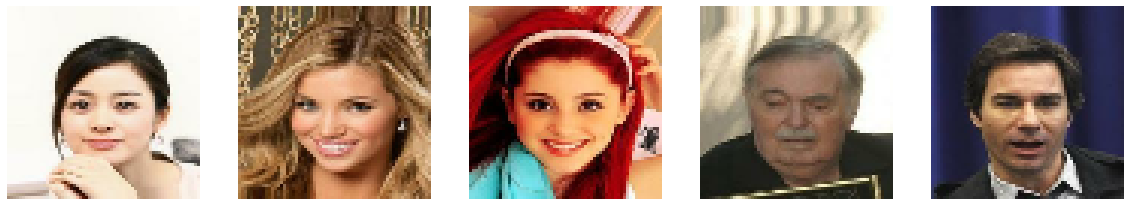

In [4]:
plt.figure(figsize=(20, 5))
for images in dataset.take(1):
    for i in range(5):
        input_shape = images[i].shape
        ax = plt.subplot(1, 5, i+1)
        plt.imshow(images[i])
        plt.axis("off")

In [5]:
discriminator = keras.Sequential([
    keras.Input(input_shape),
    layers.Conv2D(64, (3,3), padding="same", strides=2),
    layers.BatchNormalization(),
    layers.LeakyReLU(0.2),
    layers.Conv2D(128, (3,3), padding="same", strides=2),
    layers.BatchNormalization(),
    layers.LeakyReLU(0.2),
    layers.Conv2D(128, (3,3), padding="same", strides=2),
    layers.BatchNormalization(),
    layers.LeakyReLU(0.2),
    layers.Flatten(),
    layers.Dense(1, activation="sigmoid"),
    ], name='Discriminator'
)

discriminator.summary()

Model: "Discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 64)        256       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 128)       512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 128)       

In [6]:
latent_dim = 128

generator = keras.Sequential([
    keras.Input(latent_dim),
    layers.Dense(np.prod((8, 8, 128))),
    layers.Reshape((8, 8, 128)),
    layers.Conv2DTranspose(128, (3,3), padding="same", strides=2),
    layers.BatchNormalization(),
    layers.LeakyReLU(0.2),
    layers.Conv2DTranspose(256, (3,3), padding="same", strides=2),
    layers.BatchNormalization(),
    layers.LeakyReLU(0.2),
    layers.Conv2DTranspose(512, (3,3), padding="same", strides=2),
    layers.BatchNormalization(),
    layers.LeakyReLU(0.2),
    layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
    ], name="Generator"
)

generator.summary()

Model: "Generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 8192)              1056768   
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 16, 16, 128)       147584    
_________________________________________________________________
batch_normalization_3 (Batch (None, 16, 16, 128)       512       
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 32, 32, 256)       295168    
_________________________________________________________________
batch_normalization_4 (Batch (None, 32, 32, 256)       10